In [451]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,astrometry_model_vlti,rv_model,rv_model_circular,triple_model,triple_model_circular,triple_model_combined,triple_model_combined2,triple_model_vlti_combined,triple_model_vlti,triple_model_combined_circular,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model,triple_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
from uncertainties import ufloat,umath
from uncertainties.umath import *
import emcee
import corner
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [452]:
## setup paths for user
path = '/Users/tgardne/ARMADA_orbits'
path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
path_wds = '/Users/tgardne/ARMADA_orbits'
path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'

In [453]:
## Specify target
target_hd = '48581' ## HD number
note = 'circular' ## note for saved file
corrected = 'n' ## bootstrap errors?

In [454]:
query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

HIP 32140
WDS 06427-3243


In [455]:
if corrected == 'y':
    directory='%s/HD%s_bootstrap_triple/'%(path,target_hd)
else:
    directory='%s/HD%s_chi2err_triple/'%(path,target_hd)

In [456]:
## load chains
chains = np.load("%s/%s_%s_chains.npy"%(directory,target_hd,note))
print(chains.shape)

(12000, 12)


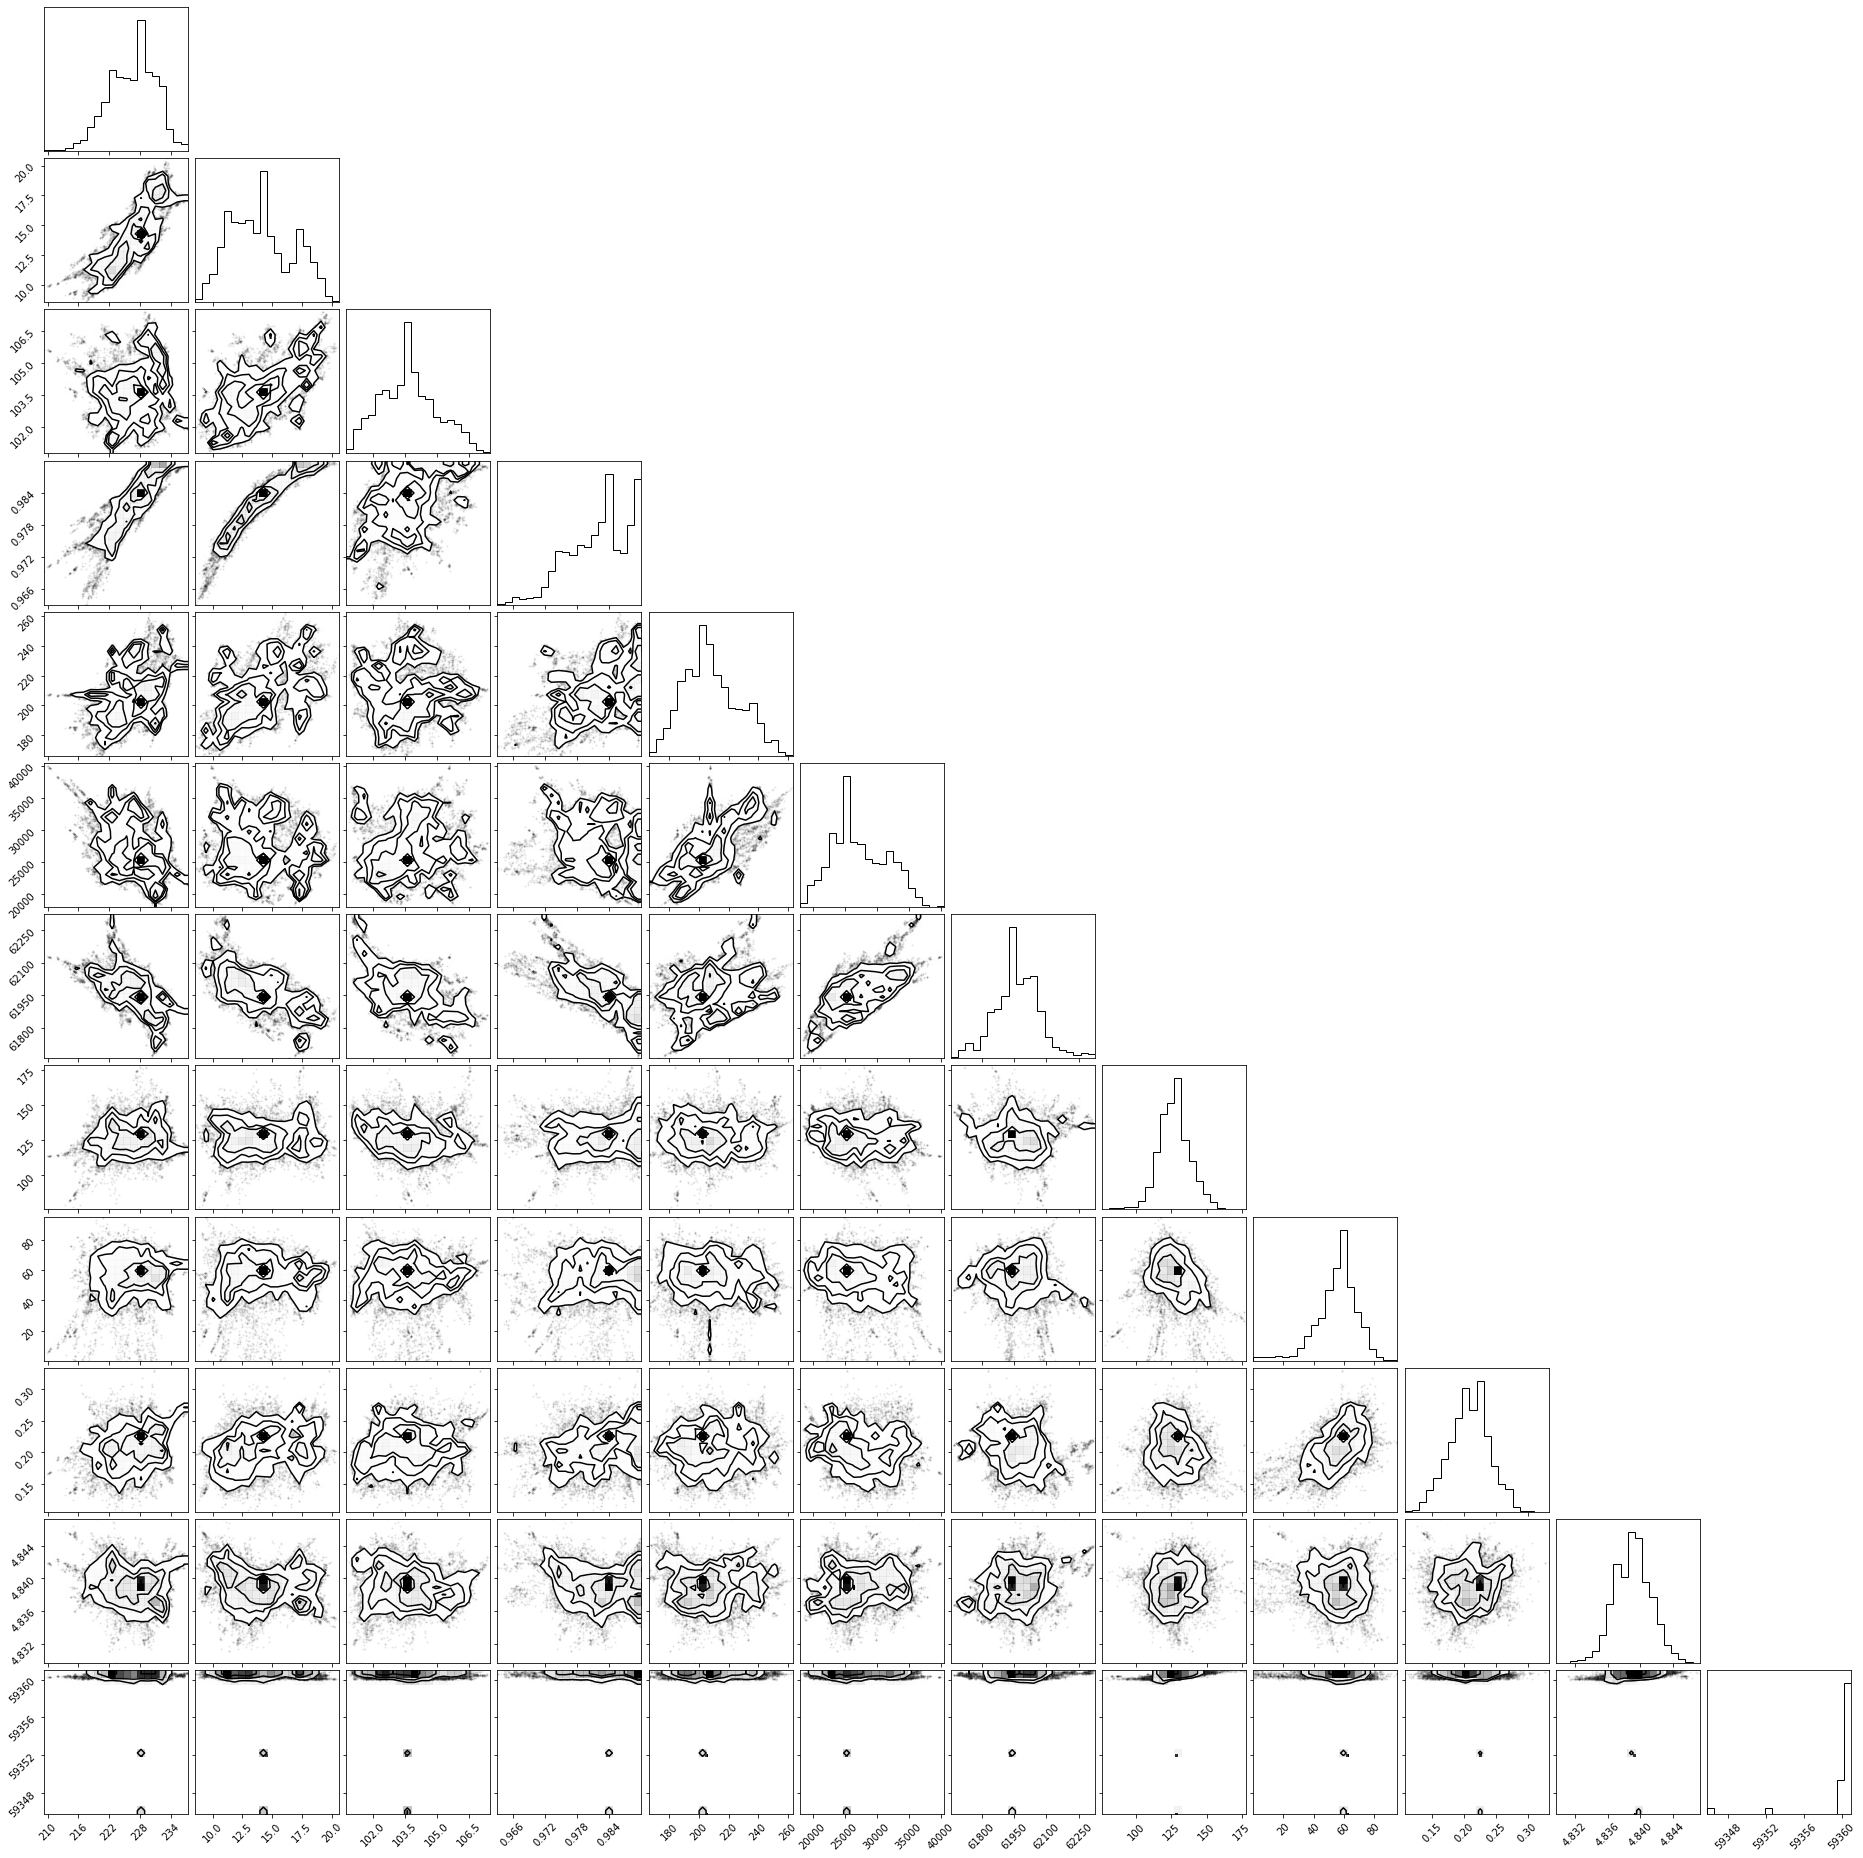

In [457]:
emcee_plot = corner.corner(chains)

## Elements for the case of Astrometry + RV1

In [439]:
circular = 'y'
vlti = 'n'
include_rv = 'y'

w_chain = chains[:,0]
bigw_chain = chains[:,1]
inc_chain = chains[:,2]
e_chain = chains[:,3]
a_chain = chains[:,4]
P_chain = chains[:,5]
T_chain = chains[:,6]

if circular=='y':
    e2_chain = np.zeros(len(chains[:,7]))
    w2_chain = np.zeros(len(chains[:,7]))
    bigw2_chain = chains[:,7]
    inc2_chain = chains[:,8]
    a2_chain = chains[:,9]
    P2_chain = chains[:,10]
    T2_chain = chains[:,11]
    if include_rv=='y':
        K_chain = chains[:,12]
        gamma_chain = chains[:,13]
    if vlti=='y':
        mirc_scale_chain = chains[:,14]
else:
    w2_chain = chains[:,7]
    e2_chain = chains[:,8]
    bigw2_chain = chains[:,9]
    inc2_chain = chains[:,10]
    a2_chain = chains[:,11]
    P2_chain = chains[:,12]
    T2_chain = chains[:,13]
    if include_rv=='y':
        K_chain = chains[:,14]
        gamma_chain = chains[:,15]
    if vlti=='y':
        mirc_scale_chain = chains[:,16]

In [440]:
file=open("%s/%s_%s_orbit_triple.txt"%(directory,target_hd,note))
for line in file.readlines():
    if line.startswith('#'):
        continue
    P_best = float(line.split()[0])
    a_best = float(line.split()[1])
    e_best = float(line.split()[2])
    inc_best = float(line.split()[3])
    w_best = float(line.split()[4])
    bigw_best = float(line.split()[5])
    T_best = float(line.split()[6])
    
    P2_best = float(line.split()[7])
    a2_best = float(line.split()[8])
    e2_best = float(line.split()[9])
    inc2_best = float(line.split()[10])
    w2_best = float(line.split()[11])
    bigw2_best = float(line.split()[12])
    T2_best = float(line.split()[13])
    mirc_scale_best = float(line.split()[14])
    
    if include_rv=='y':
        K_best = float(line.split()[15])
        gamma_best = float(line.split()[16])
    
    median_resid = float(line.split()[-1])
    
file.close()

In [441]:
P_err = ufloat(P_best,np.std(P_chain))/365.25
a_err = ufloat(a_best,np.std(a_chain))
e_err = ufloat(e_best,np.std(e_chain))
inc_err = ufloat(inc_best,np.std(inc_chain))
w_err = ufloat(w_best,np.std(w_chain))
bigw_err = ufloat(bigw_best,np.std(bigw_chain))
T_err = ufloat(T_best,np.std(T_chain))

P2_err = ufloat(P2_best,np.std(P2_chain))
a2_err = ufloat(a2_best,np.std(a2_chain))
e2_err = ufloat(e2_best,np.std(e2_chain))
inc2_err = ufloat(inc2_best,np.std(inc2_chain))
w2_err = ufloat(w2_best,np.std(w2_chain))
bigw2_err = ufloat(bigw2_best,np.std(bigw2_chain))
T2_err = ufloat(T2_best,np.std(T2_chain))
if vlti=='y':
    mirc_scale_err = ufloat(mirc_scale_best,np.std(mirc_scale_chain))

K_err = ufloat(K_best,np.std(K_chain))
gamma_err = ufloat(gamma_best,np.std(gamma_chain))

In [442]:
print('%s (AB) & %s & %s & %s & %s & %s & %s & %s & -- & -- \\\\'%(target_hd,P_err.nominal_value,a_err.nominal_value,e_err.nominal_value,inc_err.nominal_value,w_err.nominal_value,bigw_err.nominal_value,T_err.nominal_value))
print('& $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & & \\\\'%(P_err.std_dev,a_err.std_dev,e_err.std_dev,inc_err.std_dev,w_err.std_dev,bigw_err.std_dev,T_err.std_dev))
print('\\\\')
print('%s & %s & %s & %s & %s & %s & %s & %s & %s & %s \\\\'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,e2_err.nominal_value,inc2_err.nominal_value,w2_err.nominal_value,bigw2_err.nominal_value,T2_err.nominal_value,K_err.nominal_value,gamma_err.nominal_value))
print('& $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s \\\\'%(P2_err.std_dev,a2_err.std_dev,e2_err.std_dev,inc2_err.std_dev,w2_err.std_dev,bigw2_err.std_dev,T2_err.std_dev,K_err.std_dev,gamma_err.std_dev))

37711 (AB) & 118.14292537952028 & 205.1148478578892 & 0.784885709456435 & 68.89182878112949 & 337.6375384297205 & 63.484531301651884 & 61118.34175745368 & -- & -- \\
& $\pm$6.993887393188912 & $\pm$6.794094060056069 & $\pm$0.010465841371851461 & $\pm$0.6632175072437285 & $\pm$4.484778115114274 & $\pm$0.826558113758687 & $\pm$34.84323355801854 & & \\
\\
37711 & 4.770946694773222 & 0.05472815206773762 & 0.0 & 29.782406288889927 & 0.0 & 309.5933375077676 & 59529.10052106305 & -72.94386466887204 & 27.895886954566123 \\
& $\pm$0.00022585225097271656 & $\pm$0.013303769569584695 & $\pm$0.0 & $\pm$18.660490021841458 & $\pm$0.0 & $\pm$13.748725652686803 & $\pm$2.6402670851819874 & $\pm$0.347694228487075 & $\pm$0.2490366436450434 \\


In [446]:
## distance from HIP/GAIA
distance_hip = ufloat(195,31)
distance_gaia = ufloat(720,310)

## Radial Velocity parameters included
if include_rv=='y':
    semi1 = P2_err*24*60*60*K_err*(1-e2_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc2_err*np.pi/180)
    semi1_chain = P2_chain*24*60*60*-K_chain*(1-e2_chain**2)**(1/2)/(2*np.pi)/1.496e8/np.sin(inc2_chain*np.pi/180)
    #print(semi1)

    #mratio_err = K_ab_err / K_aa_err
    #d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
    d_rv = semi1 / (a2_err/1000)
    d_rv_chain = semi1_chain / (a2_chain/1000)
    #d_rv = semi1 / ((a2_err - a1_err)/1000)

    d_rv2 = ufloat(np.median(d_rv_chain),np.std(d_rv_chain))

print('Distance from HIP = ')
print(distance_hip)
print('Distance from GAIA = ')
print(distance_gaia)

if include_rv=='y':
    print('Distance from RV = ')
    print(d_rv)
    print(d_rv2)

Distance from HIP = 
195+/-31
Distance from GAIA = 
(7.2+/-3.1)e+02
Distance from RV = 
(1.2+/-0.7)e+03
(0.1+/-3.2)e+04


In [449]:
d_err = distance_hip

In [450]:
print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_err*d_err/1000)**3 / (P_err)**2
if include_rv=='y':
    sum1_chain = (a_chain*d_rv_chain/1000)**3 / (P_chain/365.25)**2
    #print('M1+M2+M3 = ',np.median(sum1_chain),np.std(sum1_chain))
print('M1+M2+M3 = %s Msun'%sum1)

## need to assume a mass
m3 = 3.046

print('-'*10)
minner_tot = sum1 - m3
if include_rv=='y':
    minner_tot_chain = sum1_chain - m3
    #print('M1+M2=',np.median(minner_tot_chain),np.std(minner_tot_chain))
print('M1+M2=',minner_tot)

a_inner_err = (minner_tot * (P2_err/365.25)**2)**(1/3) / d_err
if include_rv=='y':
    a_inner_err_chain = (minner_tot_chain * (P2_chain/365.25)**2)**(1/3) / d_rv_chain
#print(a_inner_err)
semi2 = a_inner_err*1000 - a2_err
if include_rv=='y':
    semi2_chain = a_inner_err_chain*1000 - a2_chain

mratio_inner = semi2/a2_err
if include_rv=='y':
    mratio_inner_chain = semi2_chain/a2_chain
    #print('Mratio inner = ', np.median(mratio_inner_chain),np.std(mratio_inner_chain))
print('Mratio inner = ', mratio_inner)

print('-'*10)
m1 = minner_tot / (1+1/mratio_inner)
m2 = minner_tot - m1
m3 = sum1 - m1 - m2

if include_rv=='y':
    m1_chain = minner_tot_chain / (1+1/mratio_inner_chain)
    m2_chain = minner_tot_chain - m1_chain
    m3_chain = sum1_chain - m1_chain - m2_chain
    #print('M1=', np.median(m1_chain),np.std(m1_chain))
    #print('M2=', np.median(m2_chain),np.std(m2_chain))
    #print('M3=', np.median(m3_chain),np.std(m3_chain))

print('M1=', m1)
print('M2=', m2)
print('M3=', m3)

----------
Masses from distance
----------
M1+M2+M3 = 4.6+/-2.3 Msun
----------
M1+M2= 1.5+/-2.3
Mratio inner =  5.0+/-2.6
----------
M1= 1.3+/-2.0
M2= 0.26+/-0.30
M3= 3.046+/-0


In [302]:
if include_rv=='y':
    ainner = a_inner_err*d_err
    aouter = a_err/1000*d_err
    print('a_inner = %s au'%ainner)
    print('a_outer = %s au'%aouter)

    print(' ')

mutual_inc1 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))
mutual_inc2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err+180)*np.pi/180))

print("Mutual Inclination = ", mutual_inc1*180/np.pi, 'OR', mutual_inc2*180/np.pi)

a_inner = 0.251+/-0.035 au
a_outer = 30.4+/-2.7 au
 
Mutual Inclination =  58.2+/-0.8 OR 63.1+/-3.0


## Elements for the case of Astrometry + Inner Companion

In [208]:
circular = 'n'
vlti = 'n'
include_rv = 'n'

w_chain = chains[:,0]
bigw_chain = chains[:,1]
inc_chain = chains[:,2]
e_chain = chains[:,3]
a_chain = chains[:,4]
P_chain = chains[:,5]
T_chain = chains[:,6]

if circular=='y':
    e2_chain = np.zeros(len(chains[:,7]))
    w2_chain = np.zeros(len(chains[:,7]))
    bigw2_chain = chains[:,7]
    inc2_chain = chains[:,8]
    a2_chain = chains[:,9]
    a_inner_chain = chains[:,10]
    P2_chain = chains[:,11]
    T2_chain = chains[:,12]
    if include_rv=='y':
        K_chain = chains[:,13]
        gamma_chain = chains[:,14]
    if vlti=='y':
        mirc_scale_chain = chains[:,-1]
else:
    w2_chain = chains[:,7]
    e2_chain = chains[:,8]
    bigw2_chain = chains[:,9]
    inc2_chain = chains[:,10]
    a2_chain = chains[:,11]
    a_inner_chain = chains[:,12]
    P2_chain = chains[:,13]
    T2_chain = chains[:,14]
    if include_rv=='y':
        K_chain = chains[:,15]
        gamma_chain = chains[:,16]
    if vlti=='y':
        mirc_scale_chain = chains[:,-1]

In [209]:
## 1976
#P_best = 62400
#a_best = 208
#e_best = 0.162
#inc_best = 62.8
#w_best = 306
#bigw_best = 27.8
#T_best = 33710
#P2_best = 25.4163
#a2_best = 0.42
#a_inner_best = 1.08
#e2_best = 0.05
#inc2_best = 100.7
#w2_best = 61
#bigw2_best = 339.9
#T2_best = 59476.7
#mirc_scale_best = 1.0 
#K_best = 24.2
#gamma_best = -7

## 220278
P_best = 23488
a_best = 407
e_best = 0.142
inc_best = 77.53
w_best = 178.3
bigw_best = 96.01
T_best = 53870
P2_best = 962.2
a2_best = 11.18
a_inner_best = 41.90
e2_best = 0.0518
inc2_best = 79.16
w2_best = 189
bigw2_best = 80.61
T2_best = 59269
mirc_scale_best = 1.0 

In [210]:
P_err = ufloat(P_best,np.std(P_chain))/365.25
a_err = ufloat(a_best,np.std(a_chain))
e_err = ufloat(e_best,np.std(e_chain))
inc_err = ufloat(inc_best,np.std(inc_chain))
w_err = ufloat(w_best,np.std(w_chain))
bigw_err = ufloat(bigw_best,np.std(bigw_chain))
T_err = ufloat(T_best,np.std(T_chain))

P2_err = ufloat(P2_best,np.std(P2_chain))
a2_err = ufloat(a2_best,np.std(a2_chain))
a_inner_err = ufloat(a_inner_best,np.std(a_inner_chain))
e2_err = ufloat(e2_best,np.std(e2_chain))
inc2_err = ufloat(inc2_best,np.std(inc2_chain))
w2_err = ufloat(w2_best,np.std(w2_chain))
bigw2_err = ufloat(bigw2_best,np.std(bigw2_chain))
T2_err = ufloat(T2_best,np.std(T2_chain))
if vlti=='y':
    mirc_scale_err = ufloat(mirc_scale_best,np.std(mirc_scale_chain))
if include_rv=='y':
    K_err = ufloat(K_best,np.std(K_chain))
    gamma_err = ufloat(gamma_best,np.std(gamma_chain))

In [211]:
print('%s (AB) & %s & %s & %s & %s & %s & %s & %s & -- & -- \\\\'%(target_hd,P_err.nominal_value,a_err.nominal_value,e_err.nominal_value,inc_err.nominal_value,w_err.nominal_value,bigw_err.nominal_value,T_err.nominal_value))
print('& $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & & \\\\'%(P_err.std_dev,a_err.std_dev,e_err.std_dev,inc_err.std_dev,w_err.std_dev,bigw_err.std_dev,T_err.std_dev))
print('\\\\')
print('%s & %s & %s & %s & %s & %s & %s & %s & %s & %s \\\\'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,e2_err.nominal_value,inc2_err.nominal_value,w2_err.nominal_value,bigw2_err.nominal_value,T2_err.nominal_value,K_err.nominal_value,gamma_err.nominal_value))
print('& $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s \\\\'%(P2_err.std_dev,a2_err.std_dev,e2_err.std_dev,inc2_err.std_dev,w2_err.std_dev,bigw2_err.std_dev,T2_err.std_dev,K_err.std_dev,gamma_err.std_dev))

220278 (AB) & 64.30663928815879 & 407.0 & 0.142 & 77.53 & 178.3 & 96.01 & 53870.0 & -- & -- \\
& $\pm$0.27063829904581554 & $\pm$1.9059764259831737 & $\pm$0.0031056437652790514 & $\pm$0.0892919499811372 & $\pm$1.387848135864245 & $\pm$0.08972603098259332 & $\pm$92.19073859820479 & & \\
\\
220278 & 962.2 & 11.18 & 0.0518 & 79.16 & 189.0 & 80.61 & 59269.0 & 24.2 & -7.0 \\
& $\pm$1.803406426198044 & $\pm$0.04990143189797097 & $\pm$0.003260935039684872 & $\pm$0.25149986524658213 & $\pm$6.60334738677095 & $\pm$0.27658150020666544 & $\pm$18.09064549249474 & $\pm$2.3132158903386526 & $\pm$4.090387865635417 \\


In [198]:
a_inner_err

1.08+/-0.023624022275227627

In [199]:
## distance from HIP/GAIA
distance_gaia = ufloat(406,54)
distance_hip = ufloat(307,59)

## Radial Velocity parameters included
if include_rv=='y':
    semi1 = P2_err*24*60*60*K_err*(1-e2_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc2_err*np.pi/180)
    #print(semi1)

    #mratio_err = K_ab_err / K_aa_err
    #d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
    d_rv = semi1 / (a2_err/1000)
    #d_rv = semi1 / ((a_inner_err - a2_err)/1000)

    #semi_out1 = P_err*24*60*60*K_a_err*(1-e_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc_err*np.pi/180)
    #semi_out2 = P_err*24*60*60*K_b_err*(1-e_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc_err*np.pi/180)
    #d_rv = (semi_out1+semi_out2) / (a_err/1000)

print('Distance from HIP = ')
print(distance_hip)
print('Distance from GAIA = %s pc'%(distance_gaia))
if include_rv=='y':
    print('Distance from RV = ')
    print(d_rv)

#if include_rv=='y':
#    print('Mratio from Kamps: ', K_ab_err/K_aa_err)
#    print('Mratio outer from Kamps: ', K_b_err/K_a_err)
print('Mratio from semis: ', (a_inner_err - a2_err) / a2_err)

mratio_inner = (a_inner_err - a2_err) / a2_err
#mratio_inner = K_ab_err/K_aa_err
#mratio_outer = K_b_err/K_a_err

Distance from HIP = 
(3.1+/-0.6)e+02
Distance from GAIA = (4.1+/-0.5)e+02 pc
Distance from RV = 
137+/-20
Mratio from semis:  1.57+/-0.28


In [201]:
6.348 / mratio_inner

4.039636363636363+/-0.7254563734365542

## Elements for the case of Quadruple

In [224]:
w_chain = chains[:,0]
bigw_chain = chains[:,1]
inc_chain = chains[:,2]
e_chain = chains[:,3]
a_chain = chains[:,4]
P_chain = chains[:,5]
T_chain = chains[:,6]

circular='y'
if circular=='y':
    e2_chain = np.zeros(len(chains[:,7]))
    w2_chain = np.zeros(len(chains[:,7]))
    bigw2_chain = chains[:,7]
    inc2_chain = chains[:,8]
    a2_chain = chains[:,9]
    P2_chain = chains[:,10]
    T2_chain = chains[:,11]
    
    w3_chain = chains[:,12]
    e3_chain = chains[:,13]
    bigw3_chain = chains[:,14]
    inc3_chain = chains[:,15]
    a3_chain = chains[:,16]
    P3_chain = chains[:,17]
    T3_chain = chains[:,18]
    K_chain = chains[:,19]
    gamma_chain = chains[:,20]
else:
    print('complete')

In [243]:
P_best = 21489.1194
a_best = 233.579412
e_best = 0.42861292
inc_best = 73.3922643
w_best = 359.758632
bigw_best = 221.160668
T_best = 56223.0082
    
P2_best = 6.00076390
a2_best = 0.16018484
e2_best = 0
inc2_best = 153
w2_best = 0
bigw2_best = 239.224459
T2_best = 59522.3223
mirc_scale_best = 1

P3_best = 164.242711
a3_best = 3.13317957
e3_best = 0.07330102
inc3_best = 32.6205542
w3_best = 292.070037
bigw3_best = 7.68541421
T3_best = 59475.7716
    
K_best = 18.3866323
gamma_best = -7.50368012

In [244]:
P_err = ufloat(P_best,np.std(P_chain))/365.25
a_err = ufloat(a_best,np.std(a_chain))
e_err = ufloat(e_best,np.std(e_chain))
inc_err = ufloat(inc_best,np.std(inc_chain))
w_err = ufloat(w_best,np.std(w_chain))
bigw_err = ufloat(bigw_best,np.std(bigw_chain))
T_err = ufloat(T_best,np.std(T_chain))

P2_err = ufloat(P2_best,np.std(P2_chain))
a2_err = ufloat(a2_best,np.std(a2_chain))
e2_err = ufloat(e2_best,np.std(e2_chain))
inc2_err = ufloat(inc2_best,np.std(inc2_chain))
w2_err = ufloat(w2_best,np.std(w2_chain))
bigw2_err = ufloat(bigw2_best,np.std(bigw2_chain))
T2_err = ufloat(T2_best,np.std(T2_chain))
if vlti=='y':
    mirc_scale_err = ufloat(mirc_scale_best,np.std(mirc_scale_chain))
K_err = ufloat(K_best,np.std(K_chain))
gamma_err = ufloat(gamma_best,np.std(gamma_chain))

P3_err = ufloat(P3_best,np.std(P3_chain))
a3_err = ufloat(a3_best,np.std(a3_chain))
e3_err = ufloat(e3_best,np.std(e3_chain))
inc3_err = ufloat(inc3_best,np.std(inc3_chain))
w3_err = ufloat(w3_best,np.std(w3_chain))
bigw3_err = ufloat(bigw3_best,np.std(bigw3_chain))
T3_err = ufloat(T3_best,np.std(T3_chain))

In [228]:
print('%s (AB) & %s & %s & %s & %s & %s & %s & %s & -- & -- \\\\'%(target_hd,P_err.nominal_value,a_err.nominal_value,e_err.nominal_value,inc_err.nominal_value,w_err.nominal_value,bigw_err.nominal_value,T_err.nominal_value))
print('& $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & & \\\\'%(P_err.std_dev,a_err.std_dev,e_err.std_dev,inc_err.std_dev,w_err.std_dev,bigw_err.std_dev,T_err.std_dev))
print('\\\\')
print('%s & %s & %s & %s & %s & %s & %s & %s & %s & %s \\\\'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,e2_err.nominal_value,inc2_err.nominal_value,w2_err.nominal_value,bigw2_err.nominal_value,T2_err.nominal_value,K_err.nominal_value,gamma_err.nominal_value))
print('& $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s \\\\'%(P2_err.std_dev,a2_err.std_dev,e2_err.std_dev,inc2_err.std_dev,w2_err.std_dev,bigw2_err.std_dev,T2_err.std_dev,K_err.std_dev,gamma_err.std_dev))
print('\\\\')
print('%s & %s & %s & %s & %s & %s & %s & %s & -- & -- \\\\'%(target_hd,P3_err.nominal_value,a3_err.nominal_value,e3_err.nominal_value,inc3_err.nominal_value,w3_err.nominal_value,bigw3_err.nominal_value,T3_err.nominal_value))
print('& $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s &  &  \\\\'%(P3_err.std_dev,a3_err.std_dev,e3_err.std_dev,inc3_err.std_dev,w3_err.std_dev,bigw3_err.std_dev,T3_err.std_dev))

5143 (AB) & 58.834002464065705 & 233.579412 & 0.42861292 & 73.3922643 & 359.758632 & 221.160668 & 56223.0082 & -- & -- \\
& $\pm$0.3327983249281702 & $\pm$1.4243455929098774 & $\pm$0.004038551728717163 & $\pm$0.20266398297565374 & $\pm$0.5938389049669565 & $\pm$0.12699397292228604 & $\pm$40.84785316464146 & & \\
\\
5143 & 6.0007639 & 0.16018484 & 0.0 & 179.928184 & 0.0 & 239.224459 & 59522.3223 & 18.3866323 & -7.50368012 \\
& $\pm$0.000571321039391474 & $\pm$0.030731462847816294 & $\pm$0.0 & $\pm$29.701350781903198 & $\pm$0.0 & $\pm$12.27688183869942 & $\pm$9.847455033265586 & $\pm$0.17522189925517295 & $\pm$0.1179145279299262 \\
\\
5143 & 164.242711 & 3.13317957 & 0.07330102 & 32.6205542 & 292.070037 & 7.68541421 & 59475.7716 & -- & -- \\
& $\pm$0.12663497277577435 & $\pm$0.044327418151092715 & $\pm$0.0196886025935393 & $\pm$2.0188734063120823 & $\pm$16.162899369817556 & $\pm$3.3166284512316397 & $\pm$6.5773620927719065 &  &  \\


In [229]:
## distance from HIP/GAIA
plx_hip = ufloat(0.00794,0.00073)
plx_gaia = ufloat(0.0097025,0.0001694)

## Radial Velocity parameters included
semi1 = P3_err*24*60*60*K_err*(1-e3_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc3_err)
#d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
d_rv = semi1 / ((a3_err)/1000)

print('Distance from HIP = %s pc'%(1/plx_hip))
print('Distance from GAIA = %s pc'%(1/plx_gaia))
print('Distance from RV = %s pc'%d_rv)

Distance from HIP = 126+/-12 pc
Distance from GAIA = 103.1+/-1.8 pc
Distance from RV = (9+/-7)e+01 pc


In [232]:
print('-'*10)
print('Masses from distance')
print('-'*10)
#print('mass ratio Bb/Ba = %s'%mratio_err)

d_err = 1/plx_gaia

# masses
print('distance=%s pc'%d_err)

sum1 = (a_err*d_err/1000)**3 / (P_err)**2
print('M1+M2+M3+M4 = %s Msun'%sum1)

## assume a mass
MA = 1.6
MB = 1.1

sum_new = sum1 - MA - MB

print(sum_new)

----------
Masses from distance
----------
distance=103.1+/-1.8 pc
M1+M2+M3+M4 = 4.03+/-0.23 Msun
1.33+/-0.23


In [245]:
theta = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                   umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))

theta2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)-
                    umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))



theta_out = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc3_err*np.pi/180)+
                   umath.sin(inc_err*np.pi/180)*umath.sin(inc3_err*np.pi/180)*umath.cos((bigw_err-bigw3_err)*np.pi/180))

theta_out2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc3_err*np.pi/180)-
                    umath.sin(inc_err*np.pi/180)*umath.sin(inc3_err*np.pi/180)*umath.cos((bigw_err-bigw3_err)*np.pi/180))


print(theta*180/np.pi)
print(theta2*180/np.pi)

print(theta_out*180/np.pi)
print(theta_out2*180/np.pi)

81+/-28
132+/-27
101.0+/-2.0
47.8+/-1.9
